<br>
## Arpan Tarkas<br>Indian Institute of Information Technology, Design & Manufacturing, Jabalpur

<br>
## This is my Submission to the Task 5 of the FOSSEE Web Development Fellowship 2018, IIT Bombay, in which I was given a Dataset and I had to come up with an algorithm in Python3 to classify the FOSSEE Forum Posts as Spam/Not Spam.

## Dataset : [Link](https://docs.google.com/spreadsheets/d/12OXzrKaxw3D4nFp5fwmhkBEegALeX8_reVDNeSbDTl0/edit#gid=1048948619)


## References 
* [sklearn's Official Tutorial for Working With Text Data](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)
* [Research Paper on Spam Filtering Methods](http://airccse.org/journal/jcsit/0211ijcsit12.pdf)
* Official Documentations of [sklearn](http://scikit-learn.org/stable/documentation.html), [pandas](http://pandas.pydata.org/pandas-docs/stable/), matplotlib
* [Various Classifiers](https://medium.com/machine-learning-101)
* [Regex Guide](http://www.nltk.org/book/ch03.html)


<br>
## Importing All the Required Libraries
First Step would be to import all the Required Libraries for our Machine Learning Model. I would be using Python's **scikit-learn {sklearn}** which comes packed with various Machine Learning Classifiers, **pandas**, **re** for preprocessing & cleaning data, **Python's NLTK** for **Lemmatisation** & **Tokenization** and **Matplotlib** for analsying the Patterns.



In [1]:
# Import All Required Libraries

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline


![](https://sebastianraschka.com/images/blog/2014/intro_supervised_learning/learning_algorithm_1.png)

<br>
## Loading the Dataset
Now, We Will Import the Data using Pandas & display the first 10 Rows of the Dataset. We'll use the ```pd.read_csv()``` Method and Read CSV (comma-separated values) file into DataFrame object **posts**.



In [2]:
posts = pd.read_csv('Data.csv', encoding = 'latin-1')

posts.head(10)

,Data,Label
0,Please perform the following steps :<div><br><...,Not Spam
1,"<div class=""post-text"" itemprop=""text"">\r\n<p>...",Not Spam
2,Could you please give us following &nbsp;detai...,Not Spam
3,you can also use<br><br>import os.path<br>os.p...,Not Spam
4,There is no package as&nbsp;<b>lpadmin.&nbsp;<...,Not Spam
5,"I have run the &nbsp;""<span style=""font-family...",Not Spam
6,Do you have FOSSEE laptop(http://laptop.fossee...,Not Spam
7,this is Fosse laptop<div>the command gives&nbs...,Not Spam
8,Thanks for the information.<div><br></div><div...,Not Spam
9,"<font size=""4""><span style=""line-height: 18.57...",Not Spam


<br>
## Analysing the Data
Since we have imported the Data into Pandas DataFrame Object ***posts***, We can now analyze different parts of our Data. We can get the Dimensions of our DataFrame by calling ```pd.shape``` which gives a Tuple of Dimensions. Also, ```pd.value_counts()``` will give us Counts of Different Values.

In [3]:
print(posts.shape)
posts['Label'].value_counts()

(925, 2)


Not Spam    876
Spam         46
Name: Label, dtype: int64

<br>
## Dropping Empty Rows
Now, as we can observe, Our Dataset has *925 Rows & 2 Columns*, whereas there are only *876+46 = 922 Labels*. This indicates that there are ***3 Rows Without Any Label*** {They might be Empty}. So, we remove them from our Dataset to avoid further complications.  



In [4]:
posts.drop( posts[pd.isnull( posts['Label'] )].index, inplace=True)

posts.describe()

,Data,Label
count,922,922
unique,906,2
top,You can have a look at OpenModelica. Its an op...,Not Spam
freq,4,876


<br>
## Plotting Data
We'll plot a *Donut Pie Chart* to analyze the Percentage Distribution of Spam/Not Spam Posts using **Matplotlib**.

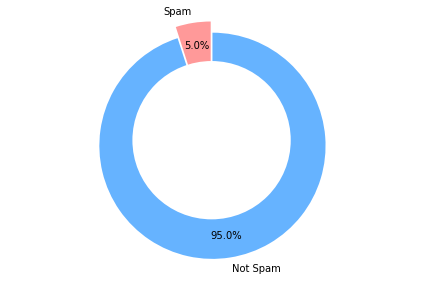

In [5]:
total_not_spam = posts['Label'].value_counts()[0]
total_spam     = posts['Label'].value_counts()[1]

labels  = ['Spam','Not Spam']
sizes   = [total_spam, total_not_spam]
colors  = ['#ff9999','#66b3ff']

explode = (0.05,0.05)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.8, explode = explode)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  
plt.tight_layout()
plt.show()


<br>
## Processing the Data


We've seen that the Data, i.e, The Forum Posts are in *HTML Markup*. *HTML Tags & Attributes* will not contribute to our predictive model except the *Links which are hidden under some false Texts*.

>  ### A *clean dataset* will allow a model to learn meaningful features and not overfit on irrelevant Noise.  

So, we remove data and Substitute with a Space between :
* ***' < ' and ' > '*** except the Anchor Tags which contains the Reference to the Links.
* ***' & ' and ' ; '***, i.e,  ``` &nbsp; &gt; &le; ``` HTML Entities
* ***' { ' and ' } '***
* Numbers, Carriage Return { \r } etc..

We Will do this preprocessing using ***Regular Expressions***. 

In [6]:
def clean(data):
    
    data = re.sub(r"\n", " ", data)
    data = re.sub(r"<[^a].*?>", ' ', data)
    data = re.sub(r"&.*?;", ' ', data)
    data = re.sub(r"{.*?}", " ", data)
    data = re.sub(r"\\r", " ", data)
    data = re.sub(r"\\n", " ", data)
    data = re.sub(r"[0-9]+", " ", data)
    
    return data

posts['Data'] = posts.Data.apply(clean)
posts.head(10)


,Data,Label
0,Please perform the following steps : ) Open...,Not Spam
1,You can use: import os.path os.path.isf...,Not Spam
2,Could you please give us following details: ...,Not Spam
3,you can also use import os.path os.path.exist...,Not Spam
4,There is no package as lpadmin. lpadmin com...,Not Spam
5,"I have run the "" sudo apt-get install cups cu...",Not Spam
6,Do you have FOSSEE laptop(http://laptop.fossee...,Not Spam
7,this is Fosse laptop the command gives DIST...,Not Spam
8,Thanks for the information. Can you perform...,Not Spam
9,Using Python We can convert it into a Sandhi...,Not Spam


<br>
## Tokenization & Lemmatisation

Now, we will ***Tokenize*** the Individual Posts, i.e, split the posts into individual words, Remove Unnecessary ***Stop Words, Punctuations, etc***,  & convert them to their base forms, i.e, ***Lemmatize***  them.

***Lemmatizing*** the dataset aims to reduce words based on an actual dictionary or vocabulary (the Lemma) and therefore will not chop off words into stemmed forms that do not carry any lexical meaning. Here we can utilize *NLTK* to initialize a ***Lemmatizer (WordNet Variant)*** to achieve this task.

Here, is a function that will do this job.

In [7]:
def lemmatise(message):
    message = message.lower()
    lemm = WordNetLemmatizer()
    
    words = TextBlob(message).words                       # Tokenization {Splitting into words}
    stop_words = stopwords.words('english')               # Importing List of Stop Words
    
    message_new = [word for word in words if word not in stop_words]
    message_new = [lemm.lemmatize(word) for word in message_new]
    
    return message_new

print('\n Before :- \n')
print(posts['Data'][550])

print('\n After :- \n')
print(lemmatise(posts['Data'][550]))


 Before :- 

 Building links is a difficult, time-consuming process as not all links are created equal. A link from an authoratative website like the Wall Street Journal will make a greater impact on a <a href="https://essays.solutions/" title="buy essay online" target="">buy essay online  <a href="http://www.wordstream.com/serp" style="background-color: rgb( ,  ,  ); color: rgb( ,  ,  ); font-family: EkMukta,  Trebuchet MS ,  Helvetica Neue , Arial, Helvetica, sans-serif; font-size:  px;">   than a link from a newly built website, but high quality links are hard to come by. This guide will teach you how to build quality links. 

 After :- 

['building', 'link', 'difficult', 'time-consuming', 'process', 'link', 'created', 'equal', 'link', 'authoratative', 'website', 'like', 'wall', 'street', 'journal', 'make', 'greater', 'impact', 'href', 'http', 'essays.solutions', 'title', 'buy', 'essay', 'online', 'target', 'buy', 'essay', 'online', 'href', 'http', 'www.wordstream.com/serp', 'style

As we can see, All the _Stop Words_ like *'is', 'a', 'are'*, etc.. are removed alongwith *Punctuation Characters!*
<br>

## WordCloud of Spam Words
Let's analyze the Spam Data. We will plot a WordCloud of Most Used Spam Words.

*A WordCloud is a collage of words and those words that are bigger in size have a high frequency. It is a visual representation of text data. It displays a list of words, the importance of each beeing shown with font size or color. This format is useful for quickly perceiving the most prominent terms.*

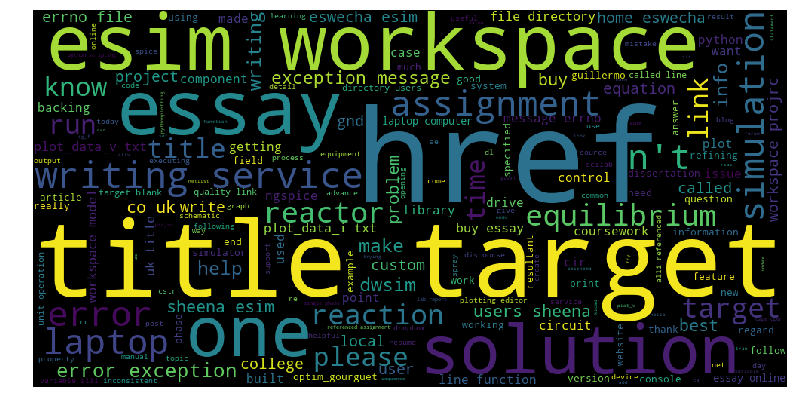

In [8]:
spam_words = ''
for post in posts[posts['Label']=='Spam']['Data']:
    spam_words = spam_words + ' '.join(lemmatise(post)) + ' '

not_spam_words = ''
for post in posts[posts['Label']=='Not Spam']['Data']:
    not_spam_words = not_spam_words + ' '.join(lemmatise(post)) + ' '

spam_wordcloud = WordCloud(width=1000, height=500, stopwords=set(STOPWORDS)).generate(spam_words)
plt.figure( figsize=(11,8) )
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


A ***WordCloud ***can only give us a glimpse of the most used words in the text. Similarly, we can also plot the WordCloud of 'Not Spam' Words. But, it won't be that much useful for our analysis. We need to know the Numerical Counts of the words for better accuracy.

Hence, we will now plot ***Frequency Distribution Bar Plots ***of 'Spam' and 'Not Spam' Words.

## Frequency Distribution of *Spam* Words

<br>

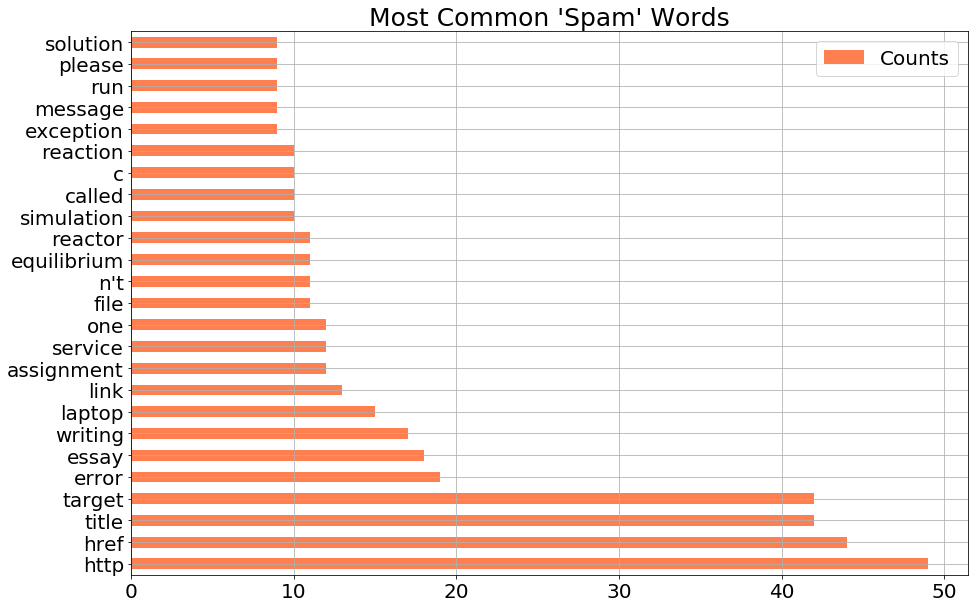

In [9]:
most_spam_words = Counter(spam_words.split()).most_common(25)

df = pd.DataFrame.from_dict(most_spam_words, orient='columns')
df.plot(kind='barh', figsize=(15,10), align='center', color='coral', grid=True)

plt.yticks(np.arange(25), df[0], fontsize=20)
plt.xticks(fontsize=20)

plt.title('Most Common \'Spam\' Words', fontsize=25)
plt.legend(('Counts',), fontsize=20)
plt.show()


<br>

## Frequency Distribution of _'Not Spam_' Words

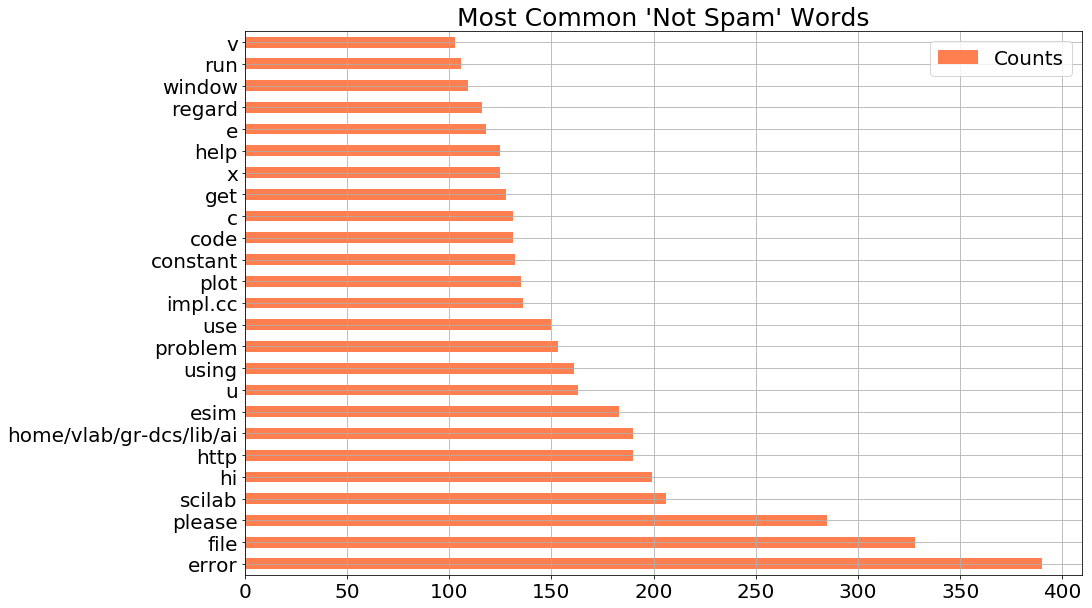

In [10]:
most_not_spam_words = Counter(not_spam_words.split()).most_common(25)

df = pd.DataFrame.from_dict(most_not_spam_words, orient='columns')
df.plot(kind='barh', figsize=(15,10), align='center', color='coral', grid=True)

plt.yticks(np.arange(25), df[0], fontsize=20)
plt.xticks(fontsize=20)

plt.title('Most Common \'Not Spam\' Words', fontsize=25)
plt.legend(('Counts',), fontsize=20)
plt.show()


<br>

*Enough Plotting! Now, let's dive into our Main Purpose!!*
<br>
## Splitting Into Train & Test Data
For the sake of evaluation of our Model, it is never ever recommended to test accuracy of our Model on the same training Data. Such evaluation tells us nothing about the true predictive power of our model. If we simply remembered each example during training, the accuracy on training data would trivially be 100%, even though we wouldn't be able to classify any new messages.

A proper way is to split the data into a **Train/Test set**, where the model only ever sees the training data during its **Model Fitting and Parameter Tuning** processes.

Hence, we will be splitting our data into 75% Training Set & 25% Testing Set using Pandas builtin ```train_test_split()``` Method.

In [11]:
posts_train, posts_test, label_train, label_test = train_test_split(posts['Data'], posts['Label'], test_size = 0.25, random_state=42)

print(' Train Data :- {} \n Test Data :- {} \n Total :- {} \n'.format(len(posts_train), len(posts_test), len(posts_train)+len(posts_test)))
print('Spam Test Data :\n\n{}'.format(posts_test[label_test == 'Spam']))


 Train Data :- 691 
 Test Data :- 231 
 Total :- 922 

Spam Test Data :

540    Just wanted to share the common <a href="https...
533     sir,        i am getting the  problem on pres...
554     -  run Cvpcb   preference   footprint librari...
541    Hi, I am Kellim Worthington i am doing masters...
561     And what is the question? Could you please cl...
545     Run   blockMesh -case pitzDaily  simpleFoam -...
577    The phrases cross in pairs and <a href="http:/...
550     Building links is a difficult, time-consuming...
572     How does one get a project abstract approved ...
551    There are a few web-based totally simulation t...
Name: Data, dtype: object


<br>
*Let's have a Glimpse to the Train & Test Data & observe the distribution of Spam Posts.*

In [12]:
print('Train Data')
print('Total %9d' % posts_train.shape[0])
print(label_train.value_counts())
print('\nTest Data')
print('Total %9d' % posts_test.shape[0])
print(label_test.value_counts())

Train Data
Total       691
Not Spam    655
Spam         36
Name: Label, dtype: int64

Test Data
Total       231
Not Spam    221
Spam         10
Name: Label, dtype: int64


<br>
## Bag of Words
In order to perform machine learning on text documents, we first need to turn the text content into numerical feature vectors.

Now, as we have cleaned & preprocessed the data, we have to convert this collection of words which are now in ***Human Readable*** format into ***Machine Readable*** format, i.e, ***Vectors***. We will have to convert our Words into Numbers or Vectors which is very commonly known as ***Bag of Words*** approach.

We will be a Using sklearn's ```CountVectorizer``` which Converts a collection of text documents to a matrix of token counts.

This implementation produces a *sparse representation* of the counts using ```scipy.sparse.csr_matrix```.

In [13]:
BoW_vect = CountVectorizer(analyzer=lemmatise, stop_words="english")

posts_train_BoW = BoW_vect.fit_transform(posts_train)
posts_test_BoW  = BoW_vect.transform(posts_test)


<br>
## TF-IDF
 _TF-IDF_ stands for ***Term Frequency-Inverse Document Frequency***. It is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in information retrieval and text mining. We will be a Using sklearn's ```TfidfVectorizer``` which is used to Convert a collection of raw documents to a matrix of ***TF-IDF features***.
 
 * ***TF: Term Frequency***, which measures how frequently a term occurs in a document. The term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization.
  * ***TF(t)*** = \\(\frac{\text{Number  of Times Term t appears in a Document}}{ \text{Total Number of Terms in the Document}} \\)

* ***IDF: Inverse Document Frequency***, which measures how important a term is. While computing TF, all terms are considered equally important. We need to weigh down the frequent terms while scale up the rare ones, by computing the following:
 - ***IDF(t)*** = \\(\log_e (\frac{\text{Total Number of Documents}}{\text{Number of Documents With Term t in it}}) \\).


```TfidfVectorizer``` is Equivalent to ```CountVectorizer``` followed by ```TfidfTransformer```. Thus, we can directly use it and escape the Middleman!
We would apply the ```fit_transform``` method which will Learn vocabulary and idf & return term-document matrix.

This is equivalent to ```fit()``` followed by ```transform()```, but more efficiently implemented which is comprised of two steps.

The first step is the fit method where the vectorizer is mapped to the the dataset. Once this is done, the actual vectorizing operation is performed via the transform method where the raw text is turned into its vector form which can be interpreted by the Machine.

In [14]:
tf_idf_vect = TfidfVectorizer(analyzer=lemmatise, stop_words="english")

posts_train_tfidf = tf_idf_vect.fit_transform(posts_train)
posts_test_tfidf  = tf_idf_vect.transform(posts_test)


<br>
Now, After this Feature Extraction Processes, We will now head on to testing some classifiers and tuning them to get the Best Accuracy Scores!!
<br>
## Testing Some Basic Classifiers
Sklearn's Library contains a Bunch of Classifiers varying from simpler *Naive Bayes*, i.e, ***BernoulliNB, GaussianNB, MultinomialNB***, etc.. to *Ensemble Classifiers*, i.e, ***RandomForestClassifier,  AdaBoostClassifier***, etc..

* ```scikit-learn``` includes several variants of the ***Naive Bayes Classifier***,  the one most suitable for *Word Counts is the Multinomial variant.*

* ***SVM {Support Vector Machines}*** *are also considered for classification problems, getting best and accurate results quickly. It s a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples.*
* ***RandomForestClassifier*** *creates a set of decision trees from randomly selected subset of training set. It then aggregates the votes from different decision trees to decide the final class of the test object.*




In [15]:
mnb      = MultinomialNB()
lin_svm  = LinearSVC()
svm      = SVC()
dtc      = DecisionTreeClassifier()
lr       = LogisticRegression()
rfc      = RandomForestClassifier()

classifiers = {
                'MNB' : mnb, 
                'LinearSVC' : lin_svm, 
                'SVC' : svm, 
                'DTC' : dtc, 
                'LR'  : lr, 
                'RFC' : rfc
              }

In [16]:
def train(model, train_posts, train_labels):
    model.fit(train_posts, train_labels)

def test(model, test_posts):
    return model.predict(test_posts)

<br>
We'll Compare the Accuracy Scores of Various Classifiers on Bag of Words Approach & Tfidf and Store the Scores in a DataFrame.

In [17]:
tfidf_scores = []
BoW_scores = []

for k,v in classifiers.items():
    train(v, posts_train_BoW, label_train)
    results = test(v, posts_test_BoW)
    BoW_scores.append((k,[accuracy_score(label_test, results)]))

for k,v in classifiers.items():
    train(v, posts_train_tfidf, label_train)
    results = test(v, posts_test_tfidf)
    tfidf_scores.append((k,[accuracy_score(label_test, results)]))

df = pd.DataFrame.from_items(BoW_scores, orient='index', columns=['BoW'])
df2 = pd.DataFrame.from_items(tfidf_scores, orient='index', columns=['TF-IDF'])

df = pd.concat([df,df2], axis=1)
df

,BoW,TF-IDF
MNB,0.969697,0.956710
LinearSVC,0.978355,0.987013
SVC,0.956710,0.956710
DTC,0.987013,0.991342
LR,0.974026,0.956710
RFC,0.961039,0.991342


We can plot a Bar Chart to analyze more clearly!

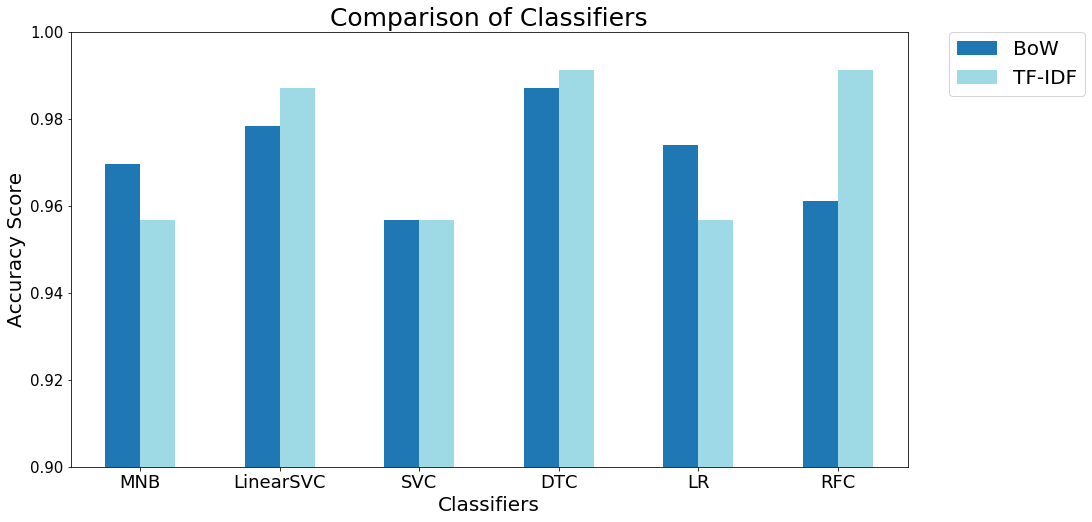

In [18]:
df.plot(kind='bar', ylim=(0.90,1.0), figsize=(15,8), align='center', colormap="tab20")

plt.xticks(np.arange(6), df.index, rotation='horizontal', fontsize=18)
plt.yticks(fontsize=15)

plt.ylabel('Accuracy Score', fontsize=20)
plt.xlabel('Classifiers', fontsize=20)
plt.title('Comparison of Classifiers', fontsize=25)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, fontsize=20, borderaxespad=0.)
plt.show()

<br>

Alongwith *High Accuracy,* our Main Goals are also to, 
* ***Avoid False Positives***, i.e, '*Not Spam*' Posts misclassified as '*Spam*'
* ***Reduce False Negatives***, i.e, '*Spam*' Posts misclassified as '*Not Spam'*.
<br>

```MultinomialNB``` and ```SVC``` doesn't seem to perform well as compared to other classifiers. Let's see if we can further optimize them.
<br>
## Hyperparameter Tuning using GridSearchCV
Now, we will Use _Hyperprameter Tuning_ to decide best parameters for our Classifiers, viz., on ```MultinomialNB``` & ```SVC```. We will use ```GridSearchCV``` which makes the job of selecting accurate parameters easy!

As  for [MultinomialNB](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes), ***Score<sub> BoW </sub>* > *Score<sub> TF-IDF </sub>*** , We'll further tune it with different parameters. 

So, Let's apply Parameter Tuning on ```MultinomialNB``` with **_Bag of Words_** Approach _{As Deducted from Above Observations}_, i.e, by using ```CountVectorizer```. It has an ```alpha``` parameter which is an *Additive (Laplace/Lidstone) smoothing parameter.* 

* ```Pipeline``` is used to sequentially apply a list of transforms and a final estimator. The purpose of the pipeline is to assemble several steps that can be *cross-validated* together while setting different parameters. For this, it enables setting parameters of the various steps using their names and the parameter name separated by a ‘__’. 

* ```GridSearchCV``` is the best way to determine optimal values for *hyperparameters* through a grid search over possible parameter values and using cross validation to evaluate the performance of the model on your data at each value.

In [19]:
pipeline = Pipeline([
                        ('BoW', BoW_vect),
                        ('nb', MultinomialNB()),
                    ])

params_mnb = {
                'nb__alpha' : (0.001, 0.01, 0.1, 1, 10)
             }

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    
    grid_mnb = GridSearchCV(pipeline, params_mnb, refit=True, n_jobs=-1, scoring='accuracy', cv=10)
    
    %time mnb_detector = grid_mnb.fit(posts_train, label_train)

    print('\nFitting & Cross Validating Train Data....\nDone!')
    print('\nTraining Best Score Based on Cross Validation :- {}\n'.format(mnb_detector.best_score_))
    
    predictions_mnb = mnb_detector.predict(posts_test)
    
    print('Running the Model on Test Data....\nDone!, Here are the Reports...\n')
    print('Confusion Matrix :-\n{}\n'.format(confusion_matrix(label_test, predictions_mnb)))
    print('Classification Report :- \n{}'.format(classification_report(label_test, predictions_mnb)))
    print('Accuracy Score :- {}\n'.format(accuracy_score(label_test, predictions_mnb)))
    
    best_parameters_mnb = mnb_detector.best_estimator_.get_params()
    print('Best Parameters :')
    for param_name in sorted(params_mnb.keys()):
        print("%s: %r" % (param_name, best_parameters_mnb[param_name]))


CPU times: user 1.44 s, sys: 320 ms, total: 1.76 s
Wall time: 28.2 s

Fitting & Cross Validating Train Data....
Done!

Training Best Score Based on Cross Validation :- 0.9652677279305355

Running the Model on Test Data....
Done!, Here are the Reports...

Confusion Matrix :-
[[219   2]
 [  2   8]]

Classification Report :- 
             precision    recall  f1-score   support

   Not Spam       0.99      0.99      0.99       221
       Spam       0.80      0.80      0.80        10

avg / total       0.98      0.98      0.98       231

Accuracy Score :- 0.9826839826839827

Best Parameters :
nb__alpha: 0.1


<br>

## Confusion Matrix

A confusion matrix is a technique for *summarizing the performance of a classification algorithm*. Calculating a confusion matrix can give you a better idea of what your classification model is getting right and what types of errors it is making.

> A Confusion Matrix isn't really Confusing!

A 2 Event Confusion Matrix is a 2x2 Matrix. Let's take our example.

                   Not Spam            Spam
    Not Spam    true positive     false positive
    Spam        false negative    true negative

**Rows are Expected Values, whereas Columns are Predicted values from our Model**. <br>Let's Define the Terminologies,
* ***True Positive {TP}*** :- Number of Correctly Predicted '*Not Spam*' Posts .
* ***False Positive {FP}*** :- Number of Incorrectly predicted '*Not Spam*' Posts.
* ***False Negative {FN}*** :- Number of Incorrectly Predicted '*Spam*' Posts.
* ***True Negative {TN}*** :- Number of Correctly Predicted '*Spam*' Posts.

and,

* ***Accuracy Score :-***  \\(\frac{\text{TP + TN}}{\text{Total}} \\)
* ***Precision :-*** \\(\frac{\text{TP}}{\text{TP + FP}} \\)
* ***Recall  :-*** \\(\frac{\text{TP}}{\text{TP + FN}} \\)
* ***f1-score  :-*** \\(\frac{\text{2 x (Recall x Precision)}}{\text{Recall + Precision}}\\)
<br>

Let's Plot the **_Confusion Matrix_**!

<br>

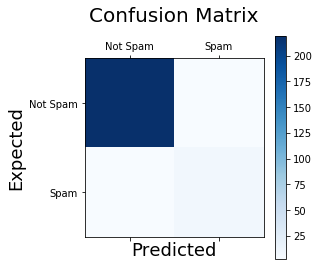

In [20]:
cnf_matrix = confusion_matrix(label_test, predictions_mnb)

plt.matshow(cnf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix\n', fontsize=20)

plt.xticks(np.arange(2),['Not Spam', 'Spam'])
plt.yticks(np.arange(2),['Not Spam', 'Spam'])

plt.ylabel('Expected', fontsize=18)
plt.xlabel('Predicted', fontsize=18)

plt.colorbar()
plt.show()


<br>
MultinomialNB doesn't seem to perform well.
Moreover, 
* There are ***2 False Positives***, i.e, *'Not Spam' *Posts misclassified as '*Spam'* 
* There are ***2 False Negatives***, i.e, *'Spam'* Posts misclassified as '*Not Spam'*.

### **We Can afford *False Negatives*, as they are the *'Spam'* Posts classified as *'Not Spam'* and we can manually remove them. But we can't afford *False Positives* as they are legitimate posts misclassified as *'Spam'* & usually we won't bother Reading Spam Posts. Hence, it would be Risky if some important posts are misclassified as Spam & get ignored by us.**


We had seen that **LinearSVC** was giving better results, as ***Score<sub> TF-IDF </sub>* > *Score<sub> BoW </sub>*** . So, let's see if we can tune some more parameters of ***SVC***  with ***Tfidf Features*** & get a better Accuracy Score.!

In [21]:
pipeline_svm = Pipeline([
                            ('tfidf', tf_idf_vect),
                            ('svc', SVC()),
                        ])

param_svm = {
                'svc__gamma' : (0.05, 0.1, 1),
                'svc__kernel' : ('linear', 'sigmoid'),
            }

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    
    grid_svm = GridSearchCV(pipeline_svm, param_svm, refit=True, n_jobs=-1, scoring='accuracy', cv=10)

    %time svm_detector = grid_svm.fit(posts_train, label_train)
    
    print('\nFitting & Cross Validating Train Data....\nDone!')
    print('\nTraining Best Score Based on Cross Validation :- {}\n'.format(svm_detector.best_score_))
    
    predictions_svm = svm_detector.predict(posts_test)
    
    print('Running the Model on Test Data....\nDone!, Here are the Reports...\n')
    print('Confusion Matrix :-\n{}\n'.format(confusion_matrix(label_test, predictions_svm)))
    print('Classification Report :- \n{}'.format(classification_report(label_test, predictions_svm)))
    print('Accuracy Score :- {}'.format(accuracy_score(label_test, predictions_svm)))
    
    best_parameters = svm_detector.best_estimator_.get_params()
    print('\nBest Parameters :- \n')
    for param_name in param_svm.keys():
        print("%s: %r" % (param_name, best_parameters[param_name]))


CPU times: user 1.44 s, sys: 316 ms, total: 1.75 s
Wall time: 34.5 s

Fitting & Cross Validating Train Data....
Done!

Training Best Score Based on Cross Validation :- 0.9696092619392185

Running the Model on Test Data....
Done!, Here are the Reports...

Confusion Matrix :-
[[221   0]
 [  2   8]]

Classification Report :- 
             precision    recall  f1-score   support

   Not Spam       0.99      1.00      1.00       221
       Spam       1.00      0.80      0.89        10

avg / total       0.99      0.99      0.99       231

Accuracy Score :- 0.9913419913419913

Best Parameters :- 

svc__gamma: 0.05
svc__kernel: 'linear'


It's ***Confusion Matrix!***

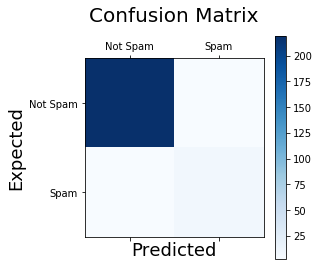

In [22]:
cnf_matrix = confusion_matrix(label_test, predictions_mnb)
plt.matshow(cnf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix\n', fontsize=20)

plt.xticks(np.arange(2),['Not Spam', 'Spam'])
plt.yticks(np.arange(2),['Not Spam', 'Spam'])

plt.ylabel('Expected', fontsize=18)
plt.xlabel('Predicted', fontsize=18)

plt.colorbar()
plt.show()


<br>

### Whoa!! We got an *Accuracy Score* of **0.991** on the Testing Data and with **0 False Positives**!! So, some tuning of *gamma* parameter of **SVC**, got us the Highest Score of All!!

So, if we now look into the *Confusion Matrix*, we can see, 
* ***2 False Negatives***, which is pretty much reasonable.
* ***0 False Positives***, which was our main goal alongwith High Accuracy Score.



For a More Detailed Analysis, We can Draw a Plot of Different _(kernel, gamma)_ Pairs and see the Variation.

<br>

,Gamma,Score
linear,0.05,0.991342
linear,0.10,0.991342
linear,0.15,0.991342


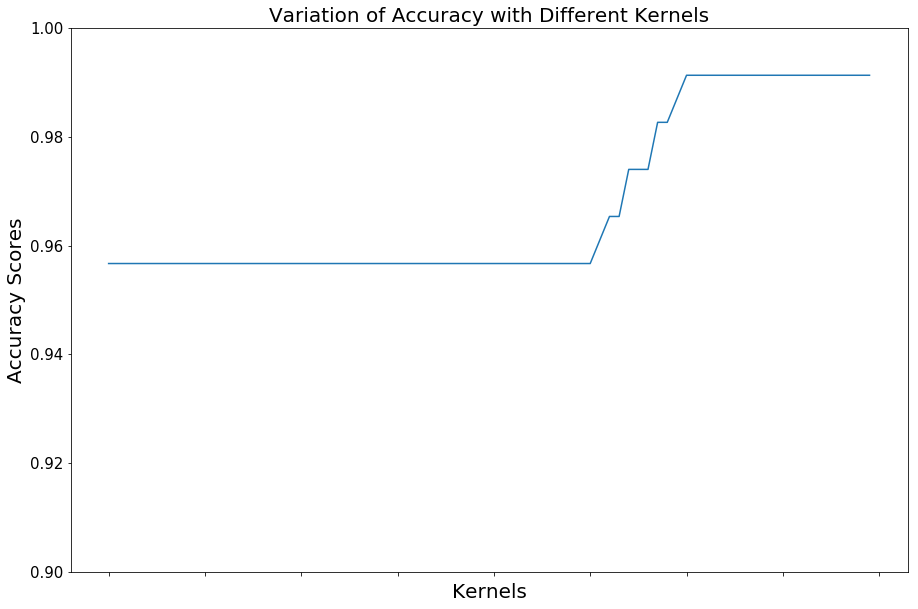

In [23]:
pred_scores = []
krnl = {'rbf' : 'rbf','polynominal' : 'poly', 'sigmoid': 'sigmoid', 'linear':'linear'}
for k,v in krnl.items():
    for i in np.linspace(0.05, 1, num=20):
        svc = SVC(kernel=v, gamma=i)
        svc.fit(posts_train_tfidf, label_train)
        pred = svc.predict(posts_test_tfidf)
        pred_scores.append((k, [i, accuracy_score(label_test,pred)]))

df = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Gamma','Score'])
df['Score'].plot(kind='line', figsize=(15,10), ylim=(0.9,1.0),colormap='tab20')

plt.title('Variation of Accuracy with Different Kernels', fontsize=20)
plt.xlabel('Kernels', fontsize=20)
plt.ylabel('Accuracy Scores', fontsize=20)
plt.yticks(fontsize=15)

df[df['Score'] == df['Score'].max()].head(3)


<br>

### ***Best Overall Accuracy Achieved*** :- **_99.13 %_**.
### ***Best Cross Validation Score :- 96.96% \\(\approx\\) 97%.***
### We had seen that **_SVMs_ with *Tf-idf Features*** are the saviours for our _Spam Filter of Forum Posts_!! 

### ***Best Parameters*** to get the *Highest Accuracy Score* were ```gamma = 0.05``` & ```kernel = 'linear'```.

## Further Improvements
We achieved an Overall Accuracy of ***0.991***! This can be further improved by *XGBoosting, Deep Learning Models, etc..*

Now, the Final Step would be to train our Model with all the Data Available to us and with the best parameters which we had found out from our Above Analysis which were :-
* We needed a Model which would give us the Best Accuracy Score without any *False Positives* & we were able to succeed!
* We observed that *Bag of Words & Tfidf* affects the Overall *Accuracy of the Model* differently.
* ```SVC(kernel = 'linear', gamma = 0.05)``` with ***Tf-idf Features*** was the *Most Accurate Combination* which we found out gave us a Score of ***0.991!***

<br>
## Model Persistence 
*After training a scikit-learn model, it is desirable to have a way to persist the model for future use without having to retrain. We can do this by Python's ```pickle```, but it may be more interesting to use sklearn's ```joblib``` replacement of ```pickle``` (joblib.dump & joblib.load), which is more efficient on objects that carry large numpy arrays internally as is often the case for fitted scikit-learn estimators, but can only pickle to the disk and not to a string.*

[More](http://scikit-learn.org/stable/modules/model_persistence.html)
<br><br>

In [24]:
from sklearn.externals import joblib

final_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(analyzer=lemmatise, stop_words='english')),
        ('svc', SVC(kernel='linear', gamma=0.05)),
    ])

predictor = final_pipeline.fit(posts['Data'], posts['Label'])

joblib.dump(predictor, 'Trained-Model.pkl')


['Trained-Model.pkl']

Later We can load back the pickled model (possibly in another Python process) with : 

```predictor = joblib.load('Trained-Model.pkl')```

<br>
<br>